In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import tensor
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import pandas as pd
import pydicom as dicom
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from PIL import Image
from skimage import exposure

from glob import glob
import os

In [169]:
if torch.cuda.is_available():
    # you can continue going on here, like cuda:1 cuda:2....etc.
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [170]:
DATA_DIR = os.path.join(".", "rsa-pneumonia-data")

TRAIN_IMAGES = os.path.join(DATA_DIR, "stage_2_train_images")
TEST_IMAGES = os.path.join(DATA_DIR, "stage_2_test_images")
PRED_MASK_DIR = os.path.join(DATA_DIR, "stage_2_mask_images")

TRAIN_ANNOTATIONS_FILE = "stage_2_train_labels.csv"
TRAIN_CLASS_FILE = "stage_2_detailed_class_info.csv"

In [171]:
class OpacityDataset(Dataset):

    def __init__(self, csv_file, root_dir, image_dir, subsample, transform=None):
        self.classes_df = pd.read_csv(csv_file)
        if subsample is not None:
            self.classes_df = self.classes_df[:subsample]
        self.root_dir = root_dir
        self.image_dir = image_dir
        self.transform = transform

        # Convert our classes to integers!
        self.class_dict = {
            "Normal": 0,
            "No Lung Opacity / Not Normal": 0,
            "Lung Opacity": 1
        }

    def __len__(self):
        return len(self.classes_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        # Get the image, preprocess it for our model
        image_path = os.path.join(
            self.image_dir, self.classes_df.iloc[index, 0])
        image = dicom.read_file(image_path + ".dcm").pixel_array
        image = image[::4, ::4]
        image = image/image.max()
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = exposure.equalize_hist(image)
        image = Image.fromarray(image).convert("RGB")
        
        opacity_class = self.classes_df.at[index, 'class']
        

        if self.transform:
            image = self.transform(image)
        
        sample = {"image": image,
                  "opacity_class": self.class_dict[opacity_class],
                  "class": opacity_class}

        return sample

In [172]:
class OpacityMaskDataset(Dataset):

    def __init__(self, csv_file, root_dir, image_dir, subsample, transform=None):
        self.classes_df = pd.read_csv(csv_file)
        if subsample is not None:
            self.classes_df = self.classes_df[:subsample]
        self.root_dir = root_dir
        self.image_dir = image_dir
        self.transform = transform

        # Convert our classes to integers!
        self.class_dict = {
            "Normal": 0,
            "No Lung Opacity / Not Normal": 0,
            "Lung Opacity": 1
        }

    def __len__(self):
        return len(self.classes_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        # Get the image, preprocess it for our model
#         image_path = os.path.join(
#             self.image_dir, self.classes_df.iloc[index, 0])
#         image = dicom.read_file(image_path + ".dcm").pixel_array
#         image = image[::4, ::4]
#         image = image/image.max()
#         image = (255*image).clip(0, 255).astype(np.uint8)
#         image = Image.fromarray(image).convert("RGB")
        image = Image.open(os.path.join(self.image_dir, self.classes_df.iloc[index, 0] + ".jpeg"))
        opacity_class = self.classes_df.at[index, 'class']

        if self.transform:
            image = self.transform(image)
        
        sample = {"image": image,
                  "opacity_class": self.class_dict[opacity_class],
                  "class": opacity_class}

        return sample

In [173]:
validation_split = 0.2;

opacity_dataset = OpacityDataset(
    csv_file=os.path.join(DATA_DIR, TRAIN_CLASS_FILE),
    root_dir=DATA_DIR,
    image_dir=TRAIN_IMAGES,
    subsample=8000,
#     subsample=None,
    transform=transforms.ToTensor()
)

dataset_size = len(opacity_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
# np.random.seed(1)
# np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Create samplers for data loading
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [174]:
# Define our NN
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, (3, 3))
#         self.pool = nn.MaxPool2d((2, 2), 2)
#         self.conv2 = nn.Conv2d(16, 32, (3, 3))
#         self.conv3 = nn.Conv2d(32, 64, (3, 3))
#         self.conv4 = nn.Conv2d(64, 128, (3, 3))
#         self.linear1 = nn.Linear(25088, 4086)
#         self.linear3 = nn.Linear(4086, 2)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = x.view(x.size()[0], -1)
#         x = F.relu(self.linear1(x))
#         x = self.linear3(x)
#         return x
    
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=2):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), 256 * 7 * 7)
#         x = self.classifier(x)
#         return x

# model = AlexNet()
# model.to(device)

In [7]:
del model
torch.cuda.ipc_collect()
torch.cuda.empty_cache()

In [175]:
# Hyperparameters
epochs = 10
num_classes = 2
batch_size = 8
learning_rate = .001

In [176]:
model = torchvision.models.resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
feature_num = model.fc.in_features
model.fc = nn.Linear(feature_num, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [177]:
# model = torchvision.models.vgg11(pretrained=False)
# model.fc = nn.Linear(4096, num_classes)
# model.to(device)

In [178]:
# model = torchvision.models.alexnet(pretrained=False)
# model.fc = nn.Linear(4096, num_classes)
# model.to(device)

In [179]:
train_loader = torch.utils.data.DataLoader(
    opacity_dataset, 
    batch_size=batch_size, 
    sampler=train_sampler,
    num_workers=0
)
validation_loader = torch.utils.data.DataLoader(
    opacity_dataset, 
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=0
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [180]:
def get_num_from_tensor(tensorItem):
    return tensorItem.cuda().cpu().numpy().item()

def get_numpy_from_tensor(tensorItem):
    return tensorItem.cuda().cpu().numpy()

In [181]:
def correct_pred_sum(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()
    return correct_pred.sum()

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = acc * 100

    return get_num_from_tensor(acc)

In [182]:
losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    running_train_acc = 0.0
    running_val_acc = 0.0
    running_loss_full = 0.0
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["opacity_class"]
        inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches          
            train_acc = multi_acc(outputs, labels)
            print("[%d, %5d] loss: %.3f training_accuracy: %.2f" % (epoch + 1, i + 1, running_loss / 50, train_acc))
            running_loss = 0.0
       
    print("Finished training epoch")
        
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data["image"], data["opacity_class"]
        inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_full += loss.item()
        running_train_acc += multi_acc(outputs, labels)
        
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data["image"], data["opacity_class"]
        inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
        outputs = model(inputs)
        running_val_acc += multi_acc(outputs, labels)
        
    curr_train_loss = running_loss_full / len(train_loader)    
    train_acc = running_train_acc / len(train_loader)
    val_acc = running_val_acc / len(validation_loader)
    
    losses.append(curr_train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
        
    print("Epoch [%d] Training Accuracy: %.3f Validation Accuracy: %.3f " % (epoch + 1, train_acc, val_acc))            
print('Finished Training')

[1,    50] loss: 0.742 training_accuracy: 37.50
[1,   100] loss: 0.767 training_accuracy: 37.50
[1,   150] loss: 0.681 training_accuracy: 50.00
[1,   200] loss: 0.633 training_accuracy: 100.00
[1,   250] loss: 0.679 training_accuracy: 37.50
[1,   300] loss: 0.666 training_accuracy: 25.00
[1,   350] loss: 0.692 training_accuracy: 50.00
[1,   400] loss: 0.659 training_accuracy: 25.00
[1,   450] loss: 0.666 training_accuracy: 50.00
[1,   500] loss: 0.700 training_accuracy: 50.00
[1,   550] loss: 0.694 training_accuracy: 50.00
[1,   600] loss: 0.637 training_accuracy: 75.00
[1,   650] loss: 0.725 training_accuracy: 25.00
[1,   700] loss: 0.709 training_accuracy: 37.50
[1,   750] loss: 0.693 training_accuracy: 50.00
[1,   800] loss: 0.614 training_accuracy: 50.00
Finished training epoch
Epoch [1] Training Accuracy: 66.312 Validation Accuracy: 57.812 
[2,    50] loss: 0.654 training_accuracy: 62.50
[2,   100] loss: 0.696 training_accuracy: 62.50
[2,   150] loss: 0.679 training_accuracy: 62.5

[10,   550] loss: 0.477 training_accuracy: 75.00
[10,   600] loss: 0.456 training_accuracy: 87.50
[10,   650] loss: 0.420 training_accuracy: 87.50
[10,   700] loss: 0.470 training_accuracy: 87.50
[10,   750] loss: 0.451 training_accuracy: 87.50
[10,   800] loss: 0.449 training_accuracy: 87.50
Finished training epoch
Epoch [10] Training Accuracy: 84.031 Validation Accuracy: 60.375 
Finished Training


In [183]:
df = pd.DataFrame(zip(losses, train_accuracies, val_accuracies), columns=["Loss", "Train Acc", "Val Acc"])
df.to_csv("resnet-high-contrast.csv")

In [29]:
df2 = pd.DataFrame(zip(train_accuracies, val_accuracies), columns=["Train Acc", "Val Acc"])
df2.head()

,Train Acc,Val Acc
0,84.828125,73.0625
1,78.390625,65.0000
2,79.859375,62.5625
3,88.953125,73.6875
4,90.937500,72.5000


In [184]:
torch.save(model.state_dict(), 'resnet-context.pth')

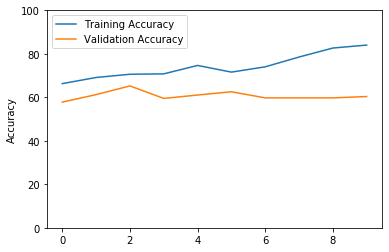

In [185]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
# plt.plot(losses, label="Loss")
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.legend()
plt.show()

In [85]:
model.load_state_dict(torch.load('resnet18-10-32.pth'))
model

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([3, 512]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).

In [186]:
results = {
    "pred 0,label 0": 0,
    "pred 0,label 1": 0,
    "pred 1,label 0": 0,
    "pred 1,label 1": 0
}

results_classes = {
    "pred 0,label 0": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    },
    "pred 0,label 1": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    },
    "pred 1,label 0": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    },
    "pred 1,label 1": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    }
}

for i, data in enumerate(validation_loader, 0):
    inputs, labels, classes = data["image"], data["opacity_class"], data["class"]
    inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
    outputs = model(inputs)
    
    y_pred_softmax = torch.log_softmax(outputs, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == labels).float()
    
    for j in range(8):
        pattern = "pred %d,label %d" % (get_num_from_tensor(y_pred_tags[j]), get_num_from_tensor(labels[j]))
        results[pattern] += 1
        results_classes[pattern][classes[j]] += 1

for key, value in results.items():
    print(key, value)
    
print()
    
for key, value in results_classes.items():
    print(key, value)

pred 0,label 0 770
pred 0,label 1 493
pred 1,label 0 137
pred 1,label 1 200

pred 0,label 0 {'Lung Opacity': 0, 'Normal': 387, 'No Lung Opacity / Not Normal': 383}
pred 0,label 1 {'Lung Opacity': 493, 'Normal': 0, 'No Lung Opacity / Not Normal': 0}
pred 1,label 0 {'Lung Opacity': 0, 'Normal': 42, 'No Lung Opacity / Not Normal': 95}
pred 1,label 1 {'Lung Opacity': 200, 'Normal': 0, 'No Lung Opacity / Not Normal': 0}


## Notes
### 10 Epochs, 32 Batch, Resnet18
* Validation values didn't increase that much past the first epoch
* Need to check class imbalance 
* Need to check the amount of values of each class that I'm missing
* Try other models with dropout 
* Clear indiciation of overfitting